目次  
1.前準備   
  
2.モデルの訓練  
2.1.アンダー・サンプリング  
2.2.パイプライン作成  
2.3.ランダムフォレスト  
2.4.決定木  
2.5.K近傍法（分類・回帰）  
2.6.ロジスティック回帰  
2.7.サポートベクトルマシン  
2.8.パーセプトロン  
2.9.確率的勾配降下法  
2.10.ナイーブベイズ分類器  
2.11.XGBoost  
2.12.交差検証（KFold, StratifiedKFold） XGBoost  
2.13.交差検証（KFold, StratifiedKFold） K近傍法（分類・回帰）  
  
3.評価  
3.1.正解率、適合率、再現率、F値  
3.2.重要度  
3.3.学習曲線  
3.4.AUC  
3.5.特徴量の再精査  
  
4.パラメータ・チューニング  
5.再学習  
6.再パラメータ・チューニング  
7.アンサンブル（スタッキング）  

# 前準備

## Jupyter notebook の表示調整

In [1]:
from IPython.display import HTML
HTML('''<script>  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide code')
    }
    code_shown= !code_shown
  }
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script><form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show code"></form>''')
from IPython.display import Javascript, display
from ipywidgets import widgets
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))
button= widgets.Button(description="Refresh")
button.on_click(run_all)
display(button)

Button(description='Refresh', style=ButtonStyle())

## ライブラリ・インポート、初期セットアップ

In [2]:
print("ライブラリ群")
print("データ処理系")
import csv
import numpy as np
import pandas as pd
from sklearn import metrics

print("データ準備")
from sklearn.model_selection import train_test_split # データ分割
from sklearn.preprocessing import StandardScaler # 標準化
from imblearn.under_sampling import RandomUnderSampler # アンダーサンプリング

print("アルゴリズム")
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
from sklearn.tree import DecisionTreeClassifier # 決定木
from sklearn.neighbors import KNeighborsClassifier # K近傍法（分類）
from sklearn.neighbors import KNeighborsRegressor # K近傍法（回帰）
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.svm import SVC # サポートベクトルマシン
from sklearn.linear_model import Perceptron # パーセプトロン
from sklearn.linear_model import SGDClassifier # 確率的勾配降下法
from sklearn.naive_bayes import GaussianNB # ナイーブベイズ分類器
import xgboost as xgb # XGBoost

print("評価")
from sklearn.metrics import confusion_matrix # 混同行列
from sklearn.model_selection import learning_curve # 学習曲線
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

print("パラメーター・チューニング")
import scipy.stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

print("アンサンブル")
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier

print("描画系")
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
from matplotlib import rcParams
import japanize_matplotlib
mplstyle.use('fast')
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style(style='dark')

print("表示調整系")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
pd.options.display.float_format = '{:.0f}'.format
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']
plt.rcParams["figure.figsize"] = [20,5]
plt.rcParams["font.size"] = 10
from IPython.core.display import display, HTML
display(HTML("<style>.cm-s-ipython span.cm-comment { color: blue; }</style>"))
from tqdm import tqdm # プログレスバー表示用

ライブラリ群
データ処理系
データ準備
アルゴリズム
評価
パラメーター・チューニング
アンサンブル
描画系
表示調整系


In [3]:
print("データ取得")
df = pd.read_csv("./considerationed.csv")

df['時間'] = df['時間'].astype(int).astype(str)
list = []
for index in tqdm(df.index):
    if (len(df['時間'][index])<4):
        list.append(df['時間'][index].zfill(4))
    else:
        list.append(df['時間'][index])
df['時間'] = list
print('時間項目を4桁の固定長に変換')

modeling = df.copy()
modeling['ジャンコード'] = modeling['ジャンコード'].astype(int)

print('対象項目')
columns = [
        '購入フラグ',
        '顧客コード',
        '性別',
        '誕生日', '年齢', '年齢グループ',
        '郵便番号', '都道府県', '市区町村', '都道府県フラグ',
        '移動距離', '移動時間',
        '買物可能フラグ', 
        'ジャンコード',
        '国コード', 
        '日付', '時間', '日付時間', 
        '数量', '売単価', '値引', '販売金額', '原単価',
        '売単価分類', '売上単価', '来店回数',
        'レシート行', 'レシート行分類', 
        'レシートNo', 'レジNo.1', 'レジNo.2', 'レジNo.3', 'レジNo.4', 'レジNo.5',
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 
]
modeling = modeling[columns]
modeling.head(2)

table = pd.DataFrame()
table['カラム名'] = modeling.columns
table

データ取得


100%|██████████| 394882/394882 [00:05<00:00, 74758.99it/s]


時間項目を4桁の固定長に変換
対象項目


,購入フラグ,顧客コード,性別,誕生日,年齢,年齢グループ,郵便番号,都道府県,市区町村,都道府県フラグ,...,レジNo.3,レジNo.4,レジNo.5,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0,10506982644,1,1942,78,1,7808015,19,90,1,...,1,0,0,1,0,0,0,0,0,0
1,0,10506982644,1,1942,78,1,7808015,19,90,1,...,1,0,0,1,0,0,0,0,0,0


,カラム名
0,購入フラグ
1,顧客コード
2,性別
3,誕生日
4,年齢
5,年齢グループ
6,郵便番号
7,都道府県
8,市区町村
9,都道府県フラグ


## 評価について

- 正解率・適合率・再現率、F値、Log損失
- 変数単体のAUC
- 学習曲線、過学習の評価
- 特徴量の重要度

# モデルの訓練

## アンダー・サンプリング

In [4]:
print("正例・負例件数")
modeling['購入フラグ'].value_counts();

正例・負例件数


月別の正例の合計数をプロット


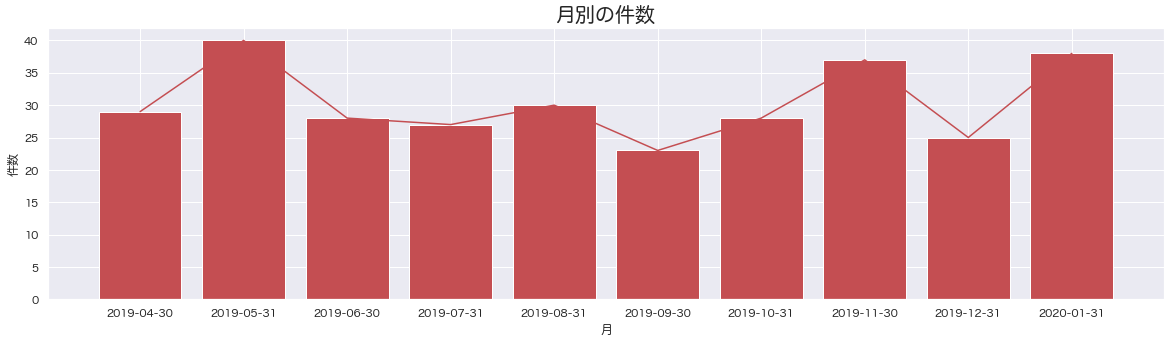

In [5]:
print("月別の正例の合計数をプロット")
index = modeling.copy()
index['日付'] = index['日付'].astype(int).astype(str)
index['時間'] = index['時間'].astype(str)
index["日付時間"] = pd.to_datetime( index['日付'].str.cat( [index['時間']], sep=' ') )
index = index.set_index('日付時間')
index = index.sort_index()

month_target = index.resample('M')['購入フラグ'].sum()
month_all = index.resample('M')['購入フラグ'].count()

x1 = month_target.index.astype(str)
y1 = month_target.values
x2 = month_all.index.astype(str)
y2 = month_all.values
plt.grid()
plt.title('月別の件数', fontsize=20)
plt.xlabel('月')
plt.ylabel('件数')
plt.plot(x1, y1, color='r')
plt.bar(x1, y1, color='r');

負例の合計数


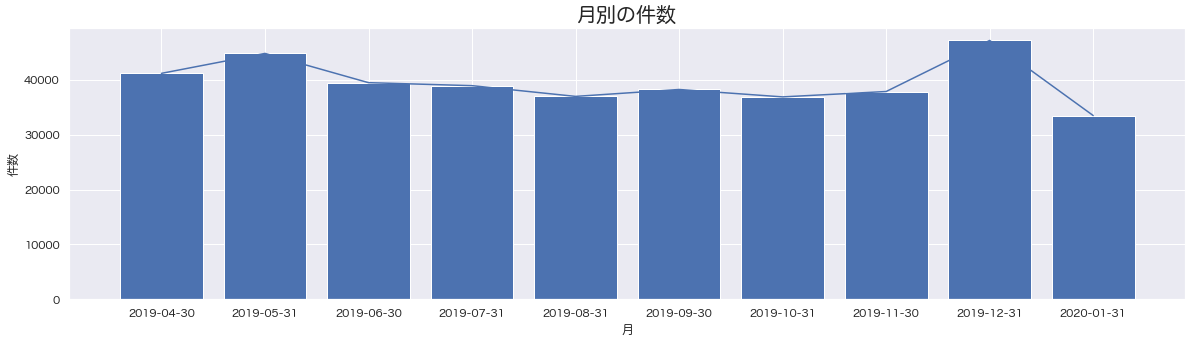

In [6]:
print("負例の合計数")
plt.grid()
plt.title('月別の件数', fontsize=20)
plt.xlabel('月')
plt.ylabel('件数')
plt.bar(x2, y2, color='b')
plt.plot(x2, y2, color='b');

In [7]:
print("不均衡データのため、負例データのアンダー・サンプリングを実施する")

target = '購入フラグ'
rs=RandomUnderSampler(random_state=42)
df_sample,_=rs.fit_resample(modeling,modeling[target])

print('*'*20)
print('＜元のデータ＞')
print('0の件数：%d'%len(df.query(f'{target}==0')))
print('1の件数：%d'%len(df.query(f'{target}==1')))
print('*'*20)
print('＜アンダーサンプリング後のデータ＞')
print('0の件数：%d'%len(df_sample.query(f'{target}==0')))
print('1の件数：%d'%len(df_sample.query(f'{target}==1')));

不均衡データのため、負例データのアンダー・サンプリングを実施する
********************
＜元のデータ＞
0の件数：394577
1の件数：305
********************
＜アンダーサンプリング後のデータ＞
0の件数：305
1の件数：305


## 全アルゴリズム

### 全パラメータ・デフォルト

In [8]:
print("学習関数")
def run_cv(model):
    target = '購入フラグ'
    Xtrain = df_sample.drop(columns=target)
    ytrain = df_sample[target]
    acc_results = []
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    for trn_index, val_index in cv.split(Xtrain, ytrain):
        X_trn, X_val = Xtrain.loc[trn_index], Xtrain.loc[val_index]
        y_trn, y_val = ytrain[trn_index], ytrain[val_index]
        model.fit(X_trn, y_trn)

        acc = model.score(X_val, y_val)
        acc_results.append(acc)
        
        return acc_results

学習関数


In [9]:
print("ロジスティック回帰")
lr_acc_results = run_cv(LogisticRegression())
lr_acc_results[0].round(decimals=3)

print("ナイーブベイズ分類器")
gnb_acc_results = run_cv(GaussianNB())
gnb_acc_results[0].round(decimals=3)

print("サポートベクターマシン")
svc_acc_results = run_cv(SVC())
svc_acc_results[0].round(decimals=3)

print("確率的勾配降下法")
sgdc_acc_results = run_cv(SGDClassifier())
sgdc_acc_results[0].round(decimals=3)

print("パーセプトロン")
pc_acc_results = run_cv(Perceptron())
pc_acc_results[0].round(decimals=3)

print("決定木")
dt_acc_results = run_cv(DecisionTreeClassifier())
dt_acc_results[0].round(decimals=3)

print("ランダムフォレスト")
rf_acc_results = run_cv(RandomForestClassifier())
rf_acc_results[0].round(decimals=3)

print("k近傍法（分類）")
knc_acc_results = run_cv(KNeighborsClassifier())
knc_acc_results[0].round(decimals=3)

print("k近傍法（回帰）")
knr_acc_results = run_cv(KNeighborsRegressor())
knr_acc_results[0].round(decimals=3)

ロジスティック回帰


0.59

ナイーブベイズ分類器


0.59

サポートベクターマシン


0.623

確率的勾配降下法


0.508

パーセプトロン


0.623

決定木


0.951

ランダムフォレスト


0.918

k近傍法（分類）


0.984

k近傍法（回帰）


0.911

### 考察

決定木の評価高。  
k近傍法の評価が異常に高いのは要考察とする。  
データが少ない為、よく分類できているとも言えるかもしれない。  
データ量を変化させた際の、評価の変化も考察する。  

## パイプライン作成

### パイプライン

In [10]:
from sklearn.pipeline import make_pipeline

print("ランダムフォレストのパイプライン")
rf_model = make_pipeline(
    RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42, n_jobs=-1),
)
print("ロジスティック回帰のパイプライン")
lr_model = make_pipeline(
    StandardScaler(), # 標準化
    LogisticRegression(max_iter=1000),
)
print("サポートベクトルマシンのパイプライン")
svm_model = make_pipeline(
    StandardScaler(), # 標準化
    SVC(C=1.0, kernel='rbf', gamma='scale'),
)
print("決定木")
dt_model = make_pipeline(
    DecisionTreeClassifier(),
)
print("K近傍法（分類）")
knc_model = make_pipeline(
    KNeighborsClassifier(),
)
print("K近傍法（回帰）")
knr_model = make_pipeline(
    KNeighborsRegressor(),
)
print("パーセプトロン")
pc_model = make_pipeline(
    Perceptron(),
)
print("確率的勾配降下法")
sgd_model = make_pipeline(
    SGDClassifier(),
)
print("ナイーブベイズ分類器")
nb_model = make_pipeline(
    GaussianNB(),
)
print("各モデル用のデータ")
target = '購入フラグ'
X = df_sample.drop(columns=target)
y = df_sample[target]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42);

ランダムフォレストのパイプライン
ロジスティック回帰のパイプライン
サポートベクトルマシンのパイプライン
決定木
K近傍法（分類）
K近傍法（回帰）
パーセプトロン
確率的勾配降下法
ナイーブベイズ分類器
各モデル用のデータ


### モデル（XGBoost）

In [11]:
print("XGBoost用のデータ")
float_df = df_sample.astype(float).copy()
Xf = float_df.drop(columns=target)
yf = float_df['購入フラグ']
X_train, X_test, y_train, y_test = train_test_split(Xf, yf, test_size=0.3, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'num_boost_round': 100
}
evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}

print("XGBoostのパイプライン")
xgb_model = xgb.train(xgb_params, dtrain, evals=evals, evals_result=evals_result);

XGBoost用のデータ
XGBoostのパイプライン
[21:14:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.49327	eval-logloss:0.52302
[1]	train-logloss:0.37685	eval-logloss:0.44396
[2]	train-logloss:0.29206	eval-logloss:0.37356
[3]	train-logloss:0.23412	eval-logloss:0.33701
[4]	train-logloss:0.18688	eval-logloss:0.30523
[5]	train-logloss:0.15614	eval-logloss:0.29724
[6]	train-logloss:0.13234	eval-logloss:0.28588
[7]	train-logloss:0.10952	eval-logloss:0.27968
[8]	train-logloss:0.09493	eval-logloss:0.27700
[9]	train-logloss:0.08475	eval-logloss:0.27056


### 関数の定義（混同行列、学習曲線）

In [12]:
print("混同行列の表示用関数")
def show_confusion_matrix(predict, test_y):
    pred =  np.where(predict > 0.5, 1, 0)
    cm = confusion_matrix(test_y, pred)
    df = pd.DataFrame(cm)
    df.columns = [['Predict_Negative', 'Predict_Positive']]
    df.index = [['Actual_Negative', 'Actual_Positive']]
    return df

混同行列の表示用関数


In [13]:
print("混同行列の表示例")
# A = Negative, B = Positive
cm_df = pd.DataFrame({
    'Predict_A': ['TN', 'FP'],
    'Predict_B': ['FN', 'TP']
}, index=['Actual_A', 'Actual_B'])
cm_df

混同行列の表示例


,Predict_A,Predict_B
Actual_A,TN,FN
Actual_B,FP,TP


In [14]:
print("ROC曲線の表示用関数")
def show_roc_curve(predict, test_y):
    pred =  np.where(predict > 0.5, 1, 0)
    fpr, tpr, thresholds = metrics.roc_curve(pred, test_y)
    plt.plot(fpr, tpr, label=f'roc_curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid()

    auc = metrics.auc(fpr, tpr)
    print('auc: {:.3f}'.format(auc));

ROC曲線の表示用関数


## ランダムフォレスト

### 学習、混同行列、ROC曲線

学習


Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', n_jobs=-1,
                                        random_state=42))])

混同行列


,Predict_Negative,Predict_Positive
Actual_Negative,94,10
Actual_Positive,12,67


ROC曲線
auc: 0.878


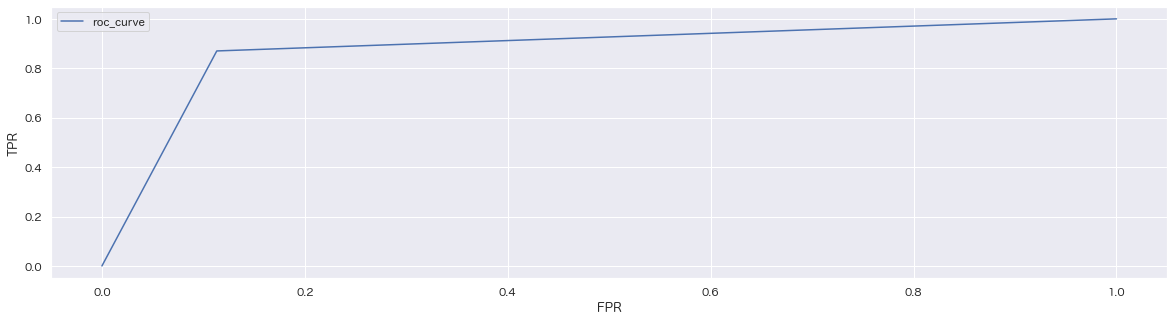

In [15]:
print('学習')
rf_model.fit(train_X, train_y)
rf_predict = rf_model.predict_proba(test_X)[:, 1]

print('混同行列')
df = show_confusion_matrix(rf_predict, test_y)
df

print('ROC曲線')

show_roc_curve(rf_predict, test_y)

## 決定木

### 学習、混同行列、ROC曲線

学習


Pipeline(steps=[('decisiontreeclassifier', DecisionTreeClassifier())])

混同行列


,Predict_Negative,Predict_Positive
Actual_Negative,84,20
Actual_Positive,9,70


ROC曲線
auc: 0.841


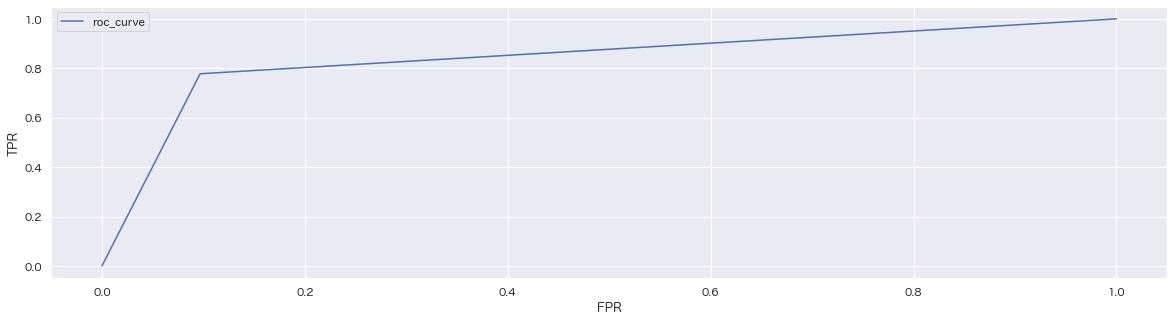

In [16]:
print('学習')
dt_model.fit(train_X, train_y)
dt_predict = dt_model.predict_proba(test_X)[:, 1]

print('混同行列')
df = show_confusion_matrix(dt_predict, test_y)
df

print('ROC曲線')
show_roc_curve(dt_predict, test_y)

## K近傍法（分類）

### 学習、混同行列、ROC曲線

学習


Pipeline(steps=[('kneighborsclassifier', KNeighborsClassifier())])

混同行列


,Predict_Negative,Predict_Positive
Actual_Negative,91,13
Actual_Positive,1,78


ROC曲線
auc: 0.923


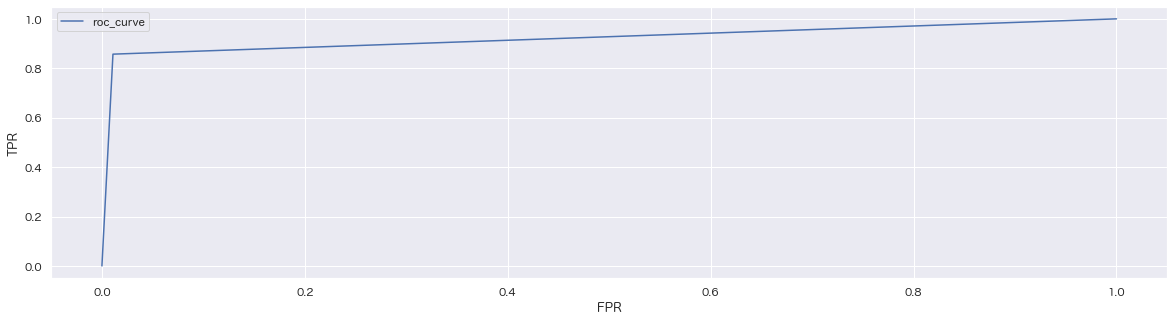

In [17]:
print('学習')
knc_model.fit(train_X, train_y)
knc_predict = knc_model.predict_proba(test_X)[:, 1]

print('混同行列')
df = show_confusion_matrix(knc_predict, test_y)
df

print('ROC曲線')
show_roc_curve(knc_predict, test_y)

## K近傍法（回帰）

### 学習、混同行列、ROC曲線

学習


Pipeline(steps=[('kneighborsregressor', KNeighborsRegressor())])

混同行列


,Predict_Negative,Predict_Positive
Actual_Negative,91,13
Actual_Positive,1,78


ROC曲線
auc: 0.923


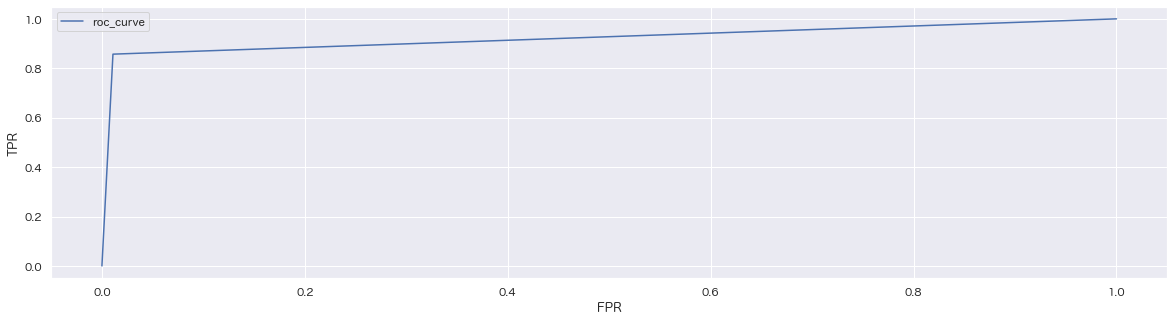

In [18]:
print('学習')
knr_model.fit(train_X, train_y)
knr_predict = knr_model.predict(test_X)

print('混同行列')
df = show_confusion_matrix(knr_predict, test_y)
df

print('ROC曲線')
show_roc_curve(knr_predict, test_y)

## ロジスティック回帰

### 学習、混同行列、ROC曲線

学習


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

混同行列


,Predict_Negative,Predict_Positive
Actual_Negative,85,19
Actual_Positive,15,64


ROC曲線
auc: 0.811


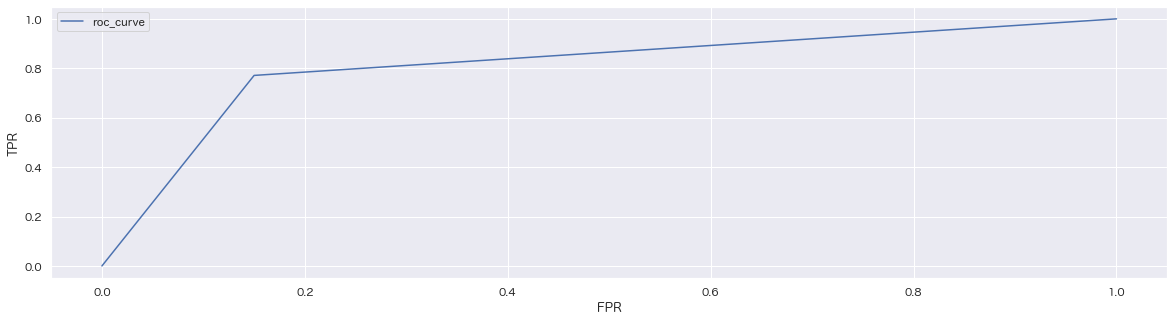

In [19]:
print('学習')
lr_model.fit(train_X, train_y)
lr_predict = lr_model.predict_proba(test_X)[:, 1]

print('混同行列')
df = show_confusion_matrix(lr_predict, test_y)
df

print('ROC曲線')
show_roc_curve(lr_predict, test_y)

## サポートベクトルマシン

### 学習、混同行列、ROC曲線

学習


Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

混同行列


,Predict_Negative,Predict_Positive
Actual_Negative,89,15
Actual_Positive,20,59


ROC曲線
auc: 0.807


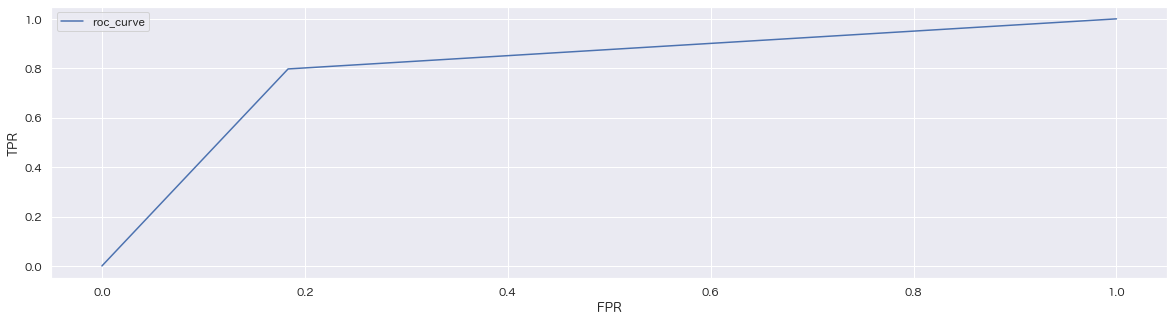

In [20]:
print('学習')
svm_model.fit(train_X, train_y)
svm_predict = svm_model.predict(test_X);

print('混同行列')
df = show_confusion_matrix(svm_predict, test_y)
df

print('ROC曲線')
show_roc_curve(svm_predict, test_y)

## パーセプトロン

### 学習、混同行列、ROC曲線

学習


Pipeline(steps=[('perceptron', Perceptron())])

混同行列


,Predict_Negative,Predict_Positive
Actual_Negative,0,104
Actual_Positive,0,79


ROC曲線
auc: nan


/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


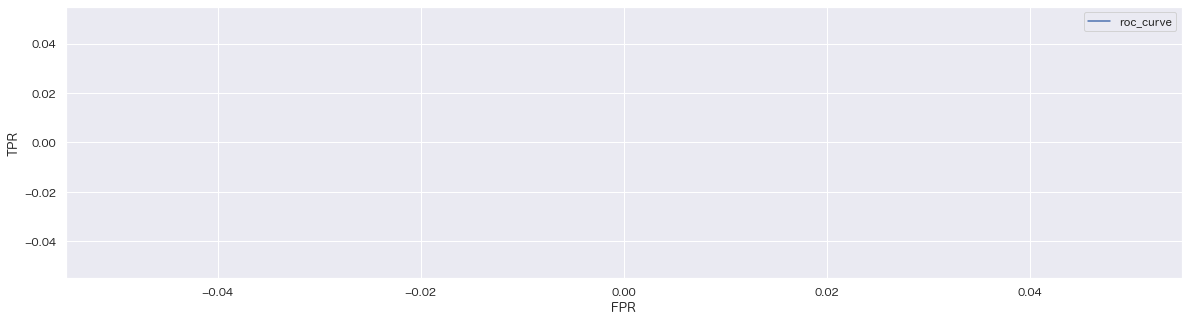

In [21]:
print('学習')
pc_model.fit(train_X, train_y)
pc_predict = pc_model.predict(test_X)

print('混同行列')
df = show_confusion_matrix(pc_predict, test_y)
df

print('ROC曲線')
show_roc_curve(pc_predict, test_y)

## 確率的勾配降下法

### 学習、混同行列、ROC曲線

学習


Pipeline(steps=[('sgdclassifier', SGDClassifier())])

混同行列


,Predict_Negative,Predict_Positive
Actual_Negative,103,1
Actual_Positive,63,16


ROC曲線
auc: 0.781


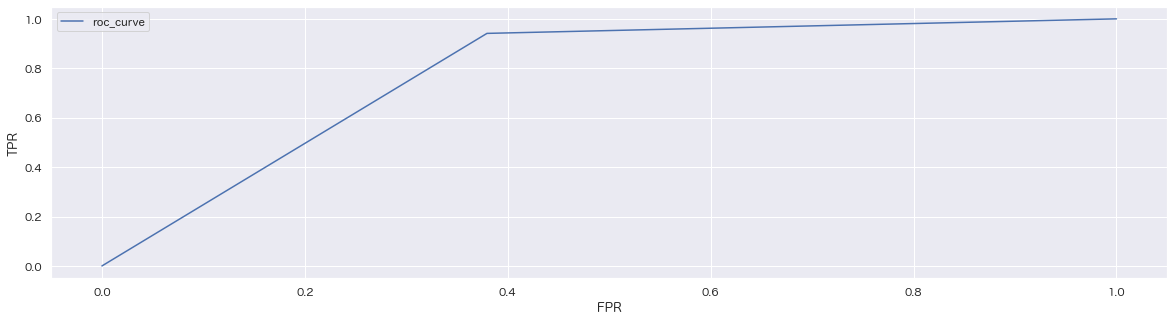

In [22]:
print('学習')
sgd_model.fit(train_X, train_y)
sgd_predict = sgd_model.predict(test_X)

print('混同行列')
df = show_confusion_matrix(sgd_predict, test_y)
df

print('ROC曲線')
show_roc_curve(sgd_predict, test_y)

## ナイーブベイズ分類器

### 学習、混同行列、ROC曲線

学習


Pipeline(steps=[('gaussiannb', GaussianNB())])

混同行列


,Predict_Negative,Predict_Positive
Actual_Negative,92,12
Actual_Positive,53,26


ROC曲線
auc: 0.659


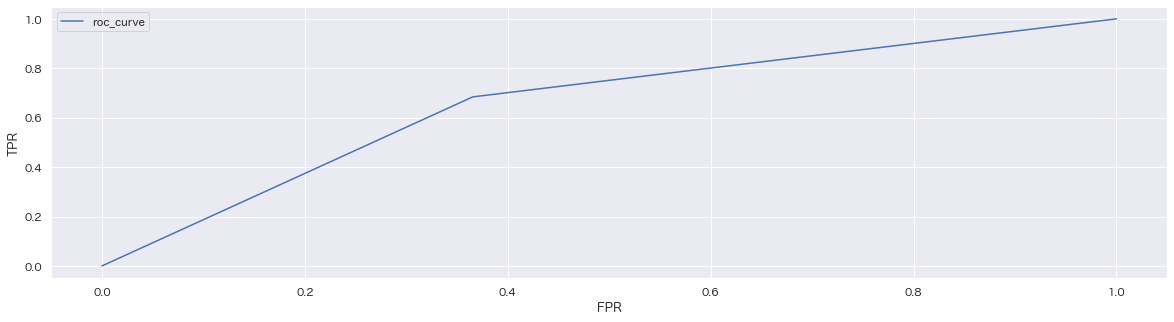

In [23]:
print('学習')
nb_model.fit(train_X, train_y)
nb_predict = nb_model.predict_proba(test_X)[:, 1]

print('混同行列')
df = show_confusion_matrix(nb_predict, test_y)
df

print('ROC曲線')
show_roc_curve(nb_predict, test_y)

## XGBoost

### 学習、混同行列、ROC曲線

学習
混同行列


,Predict_Negative,Predict_Positive
Actual_Negative,94,10
Actual_Positive,5,74


ROC曲線
auc: 0.915


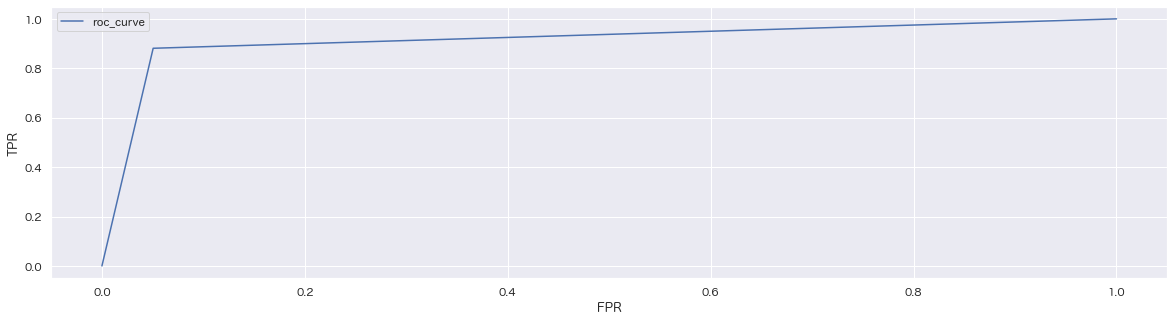

In [24]:
print('学習')
xgb_predict = xgb_model.predict(dtest)
xgb_pred = np.where(xgb_predict > 0.5, '1', '0')

print('混同行列')
df = show_confusion_matrix(xgb_predict, y_test)
df

print('ROC曲線')
show_roc_curve(xgb_predict, y_test)

## 交差検証（KFold, XGBoost）

### 学習、混同行列、ROC曲線学習

In [25]:
def xgb_training():
    auc_scores=[]
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    print("K-HoldでのXGBoost用のデータ")
    sample_float_kf = df_sample.astype(float).copy()

    xgb_params_kf = {
        'boosting_type': 'gbdt',
        'objective': 'binary:logistic', 
        'metric': {'binary_error'},
        'num_leaves': 200,
        'num_iterations':200,
        'learning_rate': 0.01,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 10,
        'max_depth':10,
        'colsample_bytree':1,
        'n_estimators':500,
        'vervose': 0,
        'num_boost_round': 100,
        'early_stopping_rounds': 100,
        'verbose_eval': 50,
    }

    auc_scores_kf = []
    for train_index_kf, val_index_kf in kf.split(df_sample.index):
        X_train_kf = sample_float_kf.drop('購入フラグ', axis=1).iloc[train_index_kf]
        y_train_kf = sample_float_kf['購入フラグ'].iloc[train_index_kf]
        X_test_kf = sample_float_kf.drop('購入フラグ', axis=1).iloc[val_index_kf]
        y_test_kf = sample_float_kf['購入フラグ'].iloc[val_index_kf]

        xgb_train_kf = xgb.DMatrix(X_train_kf, label=y_train_kf)
        xgb_test_kf = xgb.DMatrix(X_test_kf, label=y_test_kf)

        evals_kf = [(xgb_train_kf, 'train'), (xgb_test_kf, 'eval')]
        evals_result_kf = {}

        xgb_model_kf = xgb.train(
                    xgb_params_kf,
                    xgb_train_kf,
                    evals=evals_kf,
                    evals_result=evals_result_kf,
                    )
        xgb_predict_kf = xgb_model_kf.predict(xgb_test_kf)

        fpr, tpr, thresholds = metrics.roc_curve(y_test_kf, xgb_predict_kf)
        auc_kf = metrics.auc(fpr, tpr)
        auc_scores_kf.append(auc_kf)

    return xgb_model_kf, xgb_predict_kf, auc_scores_kf, y_test_kf

In [26]:
xgb_model_kf, xgb_predict_kf, auc_scores_kf, y_test_kf = xgb_training()

K-HoldでのXGBoost用のデータ
[21:14:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, early_stopping_rounds, feature_fraction, metric, n_estimators, num_boost_round, num_iterations, num_leaves, verbose_eval, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:14:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-log

k-fold-XGBoost-AUC


0.9387532462204657

混同行列


,Predict_Negative,Predict_Positive
Actual_Negative,61,8
Actual_Positive,5,48


ROC曲線
auc: 0.891


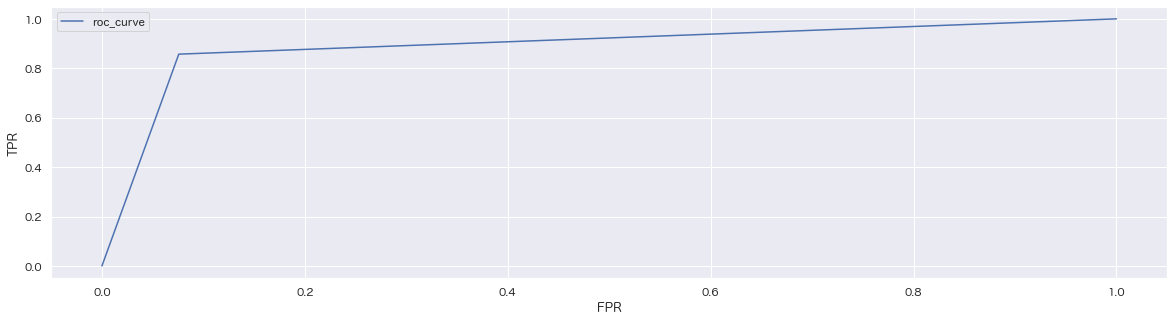

In [27]:
print("k-fold-XGBoost-AUC")
np.array(auc_scores_kf).mean()

print("混同行列")
df = show_confusion_matrix(xgb_predict_kf, y_test_kf)
df

print("ROC曲線")
show_roc_curve(xgb_predict_kf, y_test_kf)

## 交差検証（StratifiedKFold, XGBoost）

In [28]:
print("StratifiedKHold用のXGBoost用のデータ")
sample_skf_xgb = df_sample.astype(float).copy()
target = '購入フラグ'
Xtrain_skf_xgb = sample_skf_xgb.drop(columns=target)
ytrain_skf_xgb = sample_skf_xgb[target]
acc_results = []

print("パラメータ")
xgb_params_skf_xgb = {
    'boosting_type': 'gbdt',
    'objective': 'binary:logistic', 
    'metric': {'binary_error'},
    'num_leaves': 200,
    'num_iterations':200,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'max_depth':10,
    'colsample_bytree':1,
    'n_estimators':500,
    'vervose': 0,
    'num_boost_round': 100,
    'early_stopping_rounds': 100,
    'verbose_eval': 50,
}

print("学習")
auc_scores_skf_xgb = []
auc_scores=[]
xgb_predict_skf_xgb_list = []
y_val_skf_xgb_list = []
cv = StratifiedKFold(n_splits=7, random_state=0, shuffle=True)
for trn_index, val_index in cv.split(Xtrain_skf_xgb, ytrain_skf_xgb):
    X_trn_skf_xgb, X_val_skf_xgb = Xtrain_skf_xgb.loc[trn_index], Xtrain_skf_xgb.loc[val_index]
    y_trn_skf_xgb, y_val_skf_xgb = ytrain_skf_xgb[trn_index], ytrain_skf_xgb[val_index]
    y_val_skf_xgb_list.append(y_val_skf_xgb)

    xgb_train_skf_xgb = xgb.DMatrix(X_trn_skf_xgb, label=y_trn_skf_xgb)
    xgb_test_skf_xgb = xgb.DMatrix(X_val_skf_xgb, label=y_val_skf_xgb)

    evals_skf_xgb = [(xgb_train_skf_xgb, 'train'), (xgb_test_skf_xgb, 'eval')]
    evals_result_skf_xgb = {}

    xgb_model_skf_xgb = xgb.train(
                xgb_params_skf_xgb,
                xgb_train_skf_xgb,
                evals=evals_skf_xgb,
                evals_result=evals_result_skf_xgb,
                )
    xgb_predict_skf_xgb = xgb_model_skf_xgb.predict(xgb_test_skf_xgb)
    xgb_predict_skf_xgb_list.append(xgb_predict_skf_xgb)

    fpr_skf_xgb, tpr_skf_xgb, thresholds = metrics.roc_curve(y_val_skf_xgb, xgb_predict_skf_xgb)
    auc_skf_xgb = metrics.auc(fpr_skf_xgb, tpr_skf_xgb)
    auc_scores_skf_xgb.append(auc_skf_xgb)

StratifiedKHold用のXGBoost用のデータ
パラメータ
学習
[21:14:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, early_stopping_rounds, feature_fraction, metric, n_estimators, num_boost_round, num_iterations, num_leaves, verbose_eval, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:14:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behav

limit_output extension: Maximum message size of 10000 exceeded with 10044 characters

In [29]:
np.mean(auc_scores_skf_xgb).round(decimals=3)

0.934

In [30]:
print("StratifiedKHoldでのXGBoostの評価")
acc_list = []
prec_list = []
recl_list = []
f1_list = []
i = 0
for predict in xgb_predict_skf_xgb_list:
    pred_skf = np.where(predict > 0.5, 1, 0)
    accuracy = accuracy_score(y_val_skf_xgb_list[i], pred_skf).round(decimals=3)
    precision = precision_score(y_val_skf_xgb_list[i], pred_skf).round(decimals=3)
    recall = recall_score(y_val_skf_xgb_list[i], pred_skf).round(decimals=3)
    f1 = f1_score(y_val_skf_xgb_list[i], pred_skf).round(decimals=3)
    
    acc_list.append(accuracy)
    prec_list.append(precision)    
    recl_list.append(recall)
    f1_list.append(f1)
    i=i+1

acc = np.mean(acc_list).mean().round(decimals=3)
prec = np.mean(prec_list).mean().round(decimals=3)
recl = np.mean(recl_list).mean().round(decimals=3)
f = np.mean(f1_list).mean().round(decimals=3)
print(f'正解率: {acc}')
print(f'適合率: {prec}')
print(f'再現率: {recl}')
print(f'F値: {f}')

StratifiedKHoldでのXGBoostの評価
正解率: 0.893
適合率: 0.898
再現率: 0.888
F値: 0.893


## 交差検証（KFold, 近傍法（分類））

In [31]:
print("ROC曲線の表示用関数")
def show_roc_curve2(predict, test_y, i):
    pred =  np.where(predict > 0.5, 1, 0)
    fpr, tpr, thresholds = metrics.roc_curve(pred, test_y)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid()
    plt.plot(fpr, tpr, label=f'roc_curve {i}')

    auc = metrics.auc(fpr, tpr)
    print('auc: {:.3f}'.format(auc))
    
    return auc

ROC曲線の表示用関数


KFold


KNeighborsClassifier()

,Predict_Negative,Predict_Positive
Actual_Negative,30,3
Actual_Positive,1,43


No handles with labels found to put in legend.


auc: 0.951


KNeighborsClassifier()

,Predict_Negative,Predict_Positive
Actual_Negative,39,5
Actual_Positive,0,33


auc: 0.934


KNeighborsClassifier()

,Predict_Negative,Predict_Positive
Actual_Negative,26,6
Actual_Positive,2,42


auc: 0.902


KNeighborsClassifier()

,Predict_Negative,Predict_Positive
Actual_Negative,37,3
Actual_Positive,1,35


auc: 0.947


KNeighborsClassifier()

,Predict_Negative,Predict_Positive
Actual_Negative,31,1
Actual_Positive,2,42


auc: 0.958


KNeighborsClassifier()

,Predict_Negative,Predict_Positive
Actual_Negative,40,2
Actual_Positive,1,33


auc: 0.959


KNeighborsClassifier()

,Predict_Negative,Predict_Positive
Actual_Negative,40,2
Actual_Positive,0,34


auc: 0.972


KNeighborsClassifier()

,Predict_Negative,Predict_Positive
Actual_Negative,38,2
Actual_Positive,0,36


auc: 0.974
平均正解率 0.949


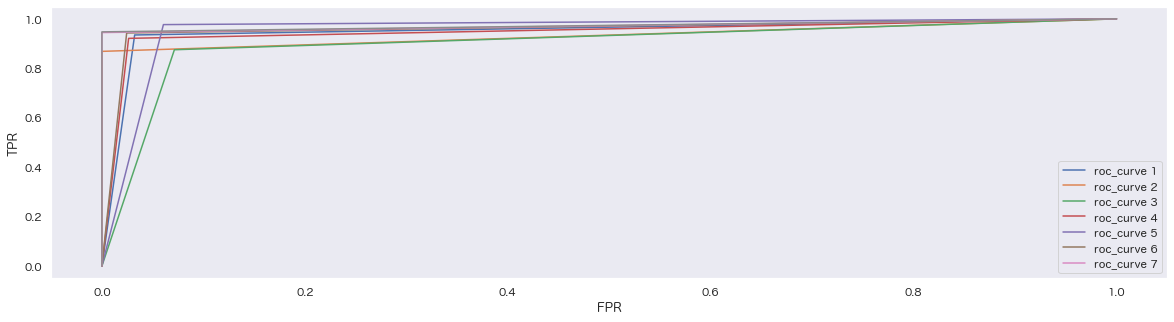

In [32]:
print("KFold")
i = 1
kn_models_kf = []
kn_predicts_kf = []
acc_results = []
auc_results = []
y_vals_kf = []

target = '購入フラグ'
Xtrain = df_sample.drop(columns=target)
ytrain = df_sample[target]
kf = KFold(n_splits=8, random_state=0, shuffle=True)

for trn_index, val_index in kf.split(Xtrain, ytrain):
    X_trn, X_val = Xtrain.loc[trn_index], Xtrain.loc[val_index]
    y_trn, y_val = ytrain[trn_index], ytrain[val_index]
    y_vals_kf.append(y_val)

    kn_model_kf = KNeighborsClassifier()
    kn_model_kf.fit(X_trn, y_trn) # 学習
    kn_models_kf.append(kn_model_kf)
    kn_predict_kf = kn_model_kf.predict_proba(X_val)[:, 1] # 予測
    kn_predicts_kf.append(kn_predict_kf)

    acc = kn_model_kf.score(X_val, y_val) # 評価
    acc_results.append(acc)
    
    kn_pred_kf = np.where(kn_predict_kf > 0.5, 1, 0) 
    df = show_confusion_matrix(kn_pred_kf, y_val) # 混同行列
    df
    
    plt.grid()
    auc = show_roc_curve2(kn_pred_kf, y_val, i) # ROC曲線
    auc_results.append(auc)
    i=i+1

accuracy_mean = np.mean(acc_results).round(decimals=3)
print(f'平均正解率 {accuracy_mean}')

In [33]:
accuracy_mean = np.mean(acc_results).round(decimals=3)
print(f'平均正解率 {accuracy_mean}')

平均正解率 0.949


## 交差検証（StratifiedKFold, K近傍法（分類））

0it [00:00, ?it/s]

StratifiedKFold


KNeighborsClassifier(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,44,0
Actual_Positive,1,43


No handles with labels found to put in legend.
1it [00:00,  7.45it/s]

auc: 0.989


KNeighborsClassifier(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,42,2
Actual_Positive,1,42


2it [00:00,  7.84it/s]

auc: 0.966


KNeighborsClassifier(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,42,2
Actual_Positive,5,38


3it [00:00,  8.17it/s]

auc: 0.922


KNeighborsClassifier(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,42,2
Actual_Positive,1,42


4it [00:00,  8.32it/s]

auc: 0.966


KNeighborsClassifier(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,43,0
Actual_Positive,4,40


5it [00:00,  8.64it/s]

auc: 0.957


KNeighborsClassifier(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,43,0
Actual_Positive,3,41


6it [00:00,  8.71it/s]

auc: 0.967


KNeighborsClassifier(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,42,1
Actual_Positive,4,40


7it [00:00,  8.77it/s]

auc: 0.944
平均正解率 0.957


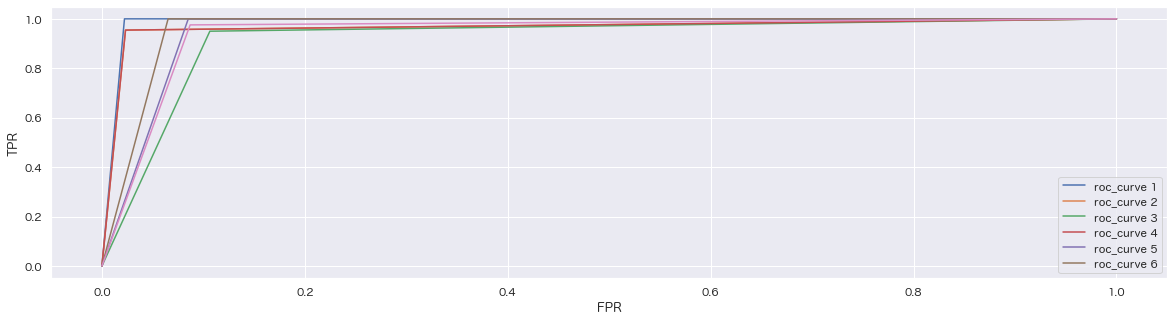

In [34]:
print("StratifiedKFold")
i = 1
kn_models_skf = []
kn_predicts_skf = []
acc_results = []
auc_results = []
y_vals_skf = []

target = '購入フラグ'
Xtrain = df_sample.drop(columns=target)
ytrain = df_sample[target]
cv = StratifiedKFold(n_splits=7, random_state=0, shuffle=True)
kn_model_skf = KNeighborsClassifier(n_neighbors=1, p=34)

for trn_index, val_index in tqdm(cv.split(Xtrain, ytrain)):
    X_trn, X_val = Xtrain.loc[trn_index], Xtrain.loc[val_index]
    y_trn, y_val = ytrain[trn_index], ytrain[val_index]
    y_vals_skf.append(y_val)

    kn_model_skf.fit(X_trn, y_trn) # 学習
    kn_models_skf.append(kn_model_skf) # モデル格納
    kn_predict_skf = kn_model_skf.predict_proba(X_val)[:, 1] # 予測
    kn_predicts_skf.append(kn_predict_skf)

    acc = kn_model_skf.score(X_val, y_val) # 評価
    acc_results.append(acc)
    
    kn_pred_skf = np.where(kn_predict_skf > 0.5, 1, 0) 
    df = show_confusion_matrix(kn_pred_skf, y_val) # 混同行列
    df
    
    auc = show_roc_curve2(kn_pred_skf, y_val, i) # ROC曲線
    auc_results.append(auc)
    i=i+1

accuracy_mean = np.mean(acc_results).round(decimals=3)
print(f'平均正解率 {accuracy_mean}')

In [35]:
accuracy_mean = np.mean(acc_results).round(decimals=3)
print(f'平均正解率 {accuracy_mean}')

平均正解率 0.957


### 考察

ホールドアウト法でも高い評価。  
StratifiedKFoldでより高い精度が出る可能性もあるが、処理時間がかなり長い為、現実的ではないと思われる。  
K近傍法は大量データには向かないアルゴリズムのようだ。40万件では処理パフォーマンンスは厳しそう。別のアルゴリズムを検討するのが妥当かもしれない。    

## 交差検証（StratifiedKFold, K近傍法（回帰））

StratifiedKFold


KNeighborsRegressor(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,44,0
Actual_Positive,1,43


No handles with labels found to put in legend.


auc: 0.989


KNeighborsRegressor(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,42,2
Actual_Positive,1,42


auc: 0.966


KNeighborsRegressor(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,42,2
Actual_Positive,5,38


auc: 0.922


KNeighborsRegressor(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,42,2
Actual_Positive,1,42


auc: 0.966


KNeighborsRegressor(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,43,0
Actual_Positive,4,40


auc: 0.957


KNeighborsRegressor(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,43,0
Actual_Positive,3,41


auc: 0.967


KNeighborsRegressor(n_neighbors=1, p=34)

,Predict_Negative,Predict_Positive
Actual_Negative,42,1
Actual_Positive,4,40


auc: 0.944


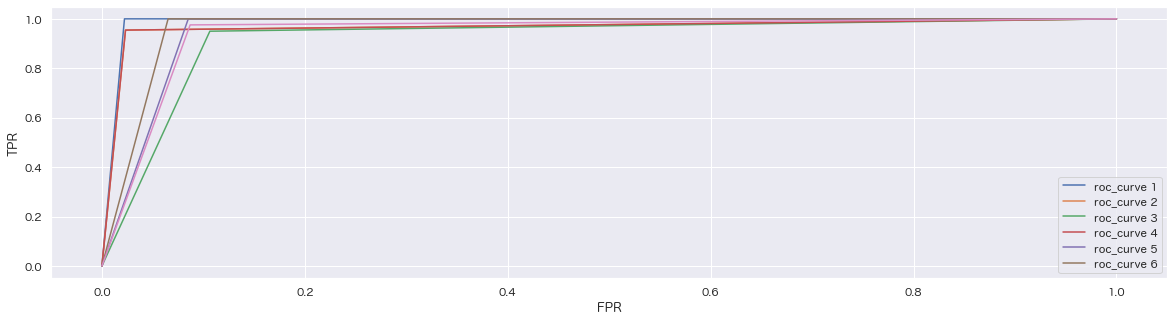

In [38]:
print("StratifiedKFold")
i = 1
knr_models_skf = []
knr_predicts_skf = []
acc_results = []
auc_results = []
y_vals_skf = []

target = '購入フラグ'
Xtrain = df_sample.drop(columns=target)
ytrain = df_sample[target]
cv = StratifiedKFold(n_splits=7, random_state=0, shuffle=True)
knr_model_skf = KNeighborsRegressor(n_neighbors=1, p=34)

for trn_index, val_index in cv.split(Xtrain, ytrain):
    X_trn, X_val = Xtrain.loc[trn_index], Xtrain.loc[val_index]
    y_trn, y_val = ytrain[trn_index], ytrain[val_index]
    y_vals_skf.append(y_val)

    knr_model_skf.fit(X_trn, y_trn) # 学習
    knr_models_skf.append(knr_model_skf) # モデル格納
    knr_predict_skf = knr_model_skf.predict(X_val) # 予測
    knr_predicts_skf.append(knr_predict_skf)

    accruacy = knr_model_skf.score(X_val, y_val) # 評価
    acc_results.append(accruacy)
    
    knr_pred_skf = np.where(knr_predict_skf > 0.5, 1, 0) 
    df = show_confusion_matrix(knr_pred_skf, y_val) # 混同行列
    df
    
    auc = show_roc_curve2(knr_pred_skf, y_val, i) # ROC曲線
    auc_results.append(auc)
    i=i+1

In [39]:
auc_mean = np.mean(auc_results).round(decimals=3)
print(f'平均正解率 {auc_mean}')

平均正解率 0.959


# 評価

## 正解率・適合率・再現率、F値

### XGBoostでの評価

In [42]:
print("XGBoostの評価")
xgb_pred = np.where(xgb_predict > 0.5, 1, 0)
accuracy = round(accuracy_score(y_test, xgb_pred), 2)
precision = round(precision_score(y_test, xgb_pred), 2)
recall = round(recall_score(y_test, xgb_pred), 2)
f1 = round(f1_score(y_test, xgb_pred), 2)

print('評価値')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}');

XGBoostの評価
評価値
accuracy: 0.92
precision: 0.88
recall: 0.94
f1: 0.91


### XGBoost（KFold）での評価

In [43]:
print("K-HoldでのXGBoostの評価")
xgb_pred_kf = np.where(xgb_predict_kf > 0.5, 1, 0)
accuracy_kf = round(accuracy_score(y_test_kf, xgb_pred_kf), 2)
precision_kf = round(precision_score(y_test_kf, xgb_pred_kf), 2)
recall_kf = round(recall_score(y_test_kf, xgb_pred_kf), 2)
f1_kf = round(f1_score(y_test_kf, xgb_pred_kf), 2)

print(f'accuracy: {accuracy_kf}')
print(f'precision: {precision_kf}')
print(f'recall: {recall_kf}')
print(f'f1: {f1_kf}');

K-HoldでのXGBoostの評価
accuracy: 0.89
precision: 0.86
recall: 0.91
f1: 0.88


#### 考察

K-Hold評価が低下しているため、理由を考察する。他の分割方法を試して比較検討する。  
複雑なモデルで評価が芳しくないが、これは主成分が多い？（20個）ことが影響しているのだろうか。特徴量を精査し、再度学習・評価してみることとする。  

### K近傍法での評価（KFold）

In [44]:
print("KFold")
acc_list = []
prec_list = []
recl_list = []
f1_list = []
i = 0
for predict in tqdm(kn_predicts_kf):
    pred_skf = np.where(predict > 0.5, 1, 0)
    accuracy = accuracy_score(y_vals_kf[i], pred_skf).round(decimals=3)
    precision = precision_score(y_vals_kf[i], pred_skf).round(decimals=3)
    recall = recall_score(y_vals_kf[i], pred_skf).round(decimals=3)
    f1 = f1_score(y_vals_kf[i], pred_skf).round(decimals=3)
    
    acc_list.append(accuracy)
    prec_list.append(precision)    
    recl_list.append(recall)
    f1_list.append(f1)
    i=i+1

acc = np.mean(acc_list).mean().round(decimals=3)
prec = np.mean(prec_list).mean().round(decimals=3)
recl = np.mean(recl_list).mean().round(decimals=3)
f = np.mean(f1_list).mean().round(decimals=3)
print(f'正解率: {acc}')
print(f'適合率: {prec}')
print(f'再現率: {recl}')
print(f'F値: {f}')

100%|██████████| 8/8 [00:00<00:00, 197.11it/s]

KFold
正解率: 0.949
適合率: 0.926
再現率: 0.979
F値: 0.952


### K近傍法での評価（StratifiedKFold）

In [45]:
print("StratifiedKHoldでのK近傍法の評価")
acc_list = []
prec_list = []
recl_list = []
f1_list = []
i = 0
for predict in tqdm(kn_predicts_skf):
    pred_skf = np.where(predict > 0.5, 1, 0)
    accuracy = accuracy_score(y_vals_skf[i], pred_skf).round(decimals=3)
    precision = precision_score(y_vals_skf[i], pred_skf).round(decimals=3)
    recall = recall_score(y_vals_skf[i], pred_skf).round(decimals=3)
    f1 = f1_score(y_vals_skf[i], pred_skf).round(decimals=3)
    
    acc_list.append(accuracy)
    prec_list.append(precision)    
    recl_list.append(recall)
    f1_list.append(f1)
    i=i+1

acc = np.mean(acc_list).mean().round(decimals=3)
prec = np.mean(prec_list).mean().round(decimals=3)
recl = np.mean(recl_list).mean().round(decimals=3)
f = np.mean(f1_list).mean().round(decimals=3)
print(f'正解率: {acc}')
print(f'適合率: {prec}')
print(f'再現率: {recl}')
print(f'F値: {f}')

100%|██████████| 7/7 [00:00<00:00, 234.28it/s]

StratifiedKHoldでのK近傍法の評価
正解率: 0.958
適合率: 0.977
再現率: 0.938
F値: 0.956


#### 考察

対象の顧客を漏れなく予測したい。  
その為、陽性・偽陰性の比率(true Positive(TP)、not false Negatibe(FN))を重視したい。  
※TPはできる限り漏れなく、FNは少ないことを重視する。  
よってRecallの評価値を重視する。  
K近傍法の評価が高い。対象顧客は共通の属性が多いのでは。つまりは木系のアルゴリズムで分岐判断するより、近しい顧客を求めることでより正しく予測できたのではないか。  

## 重要度

各変数の重要度をプロット


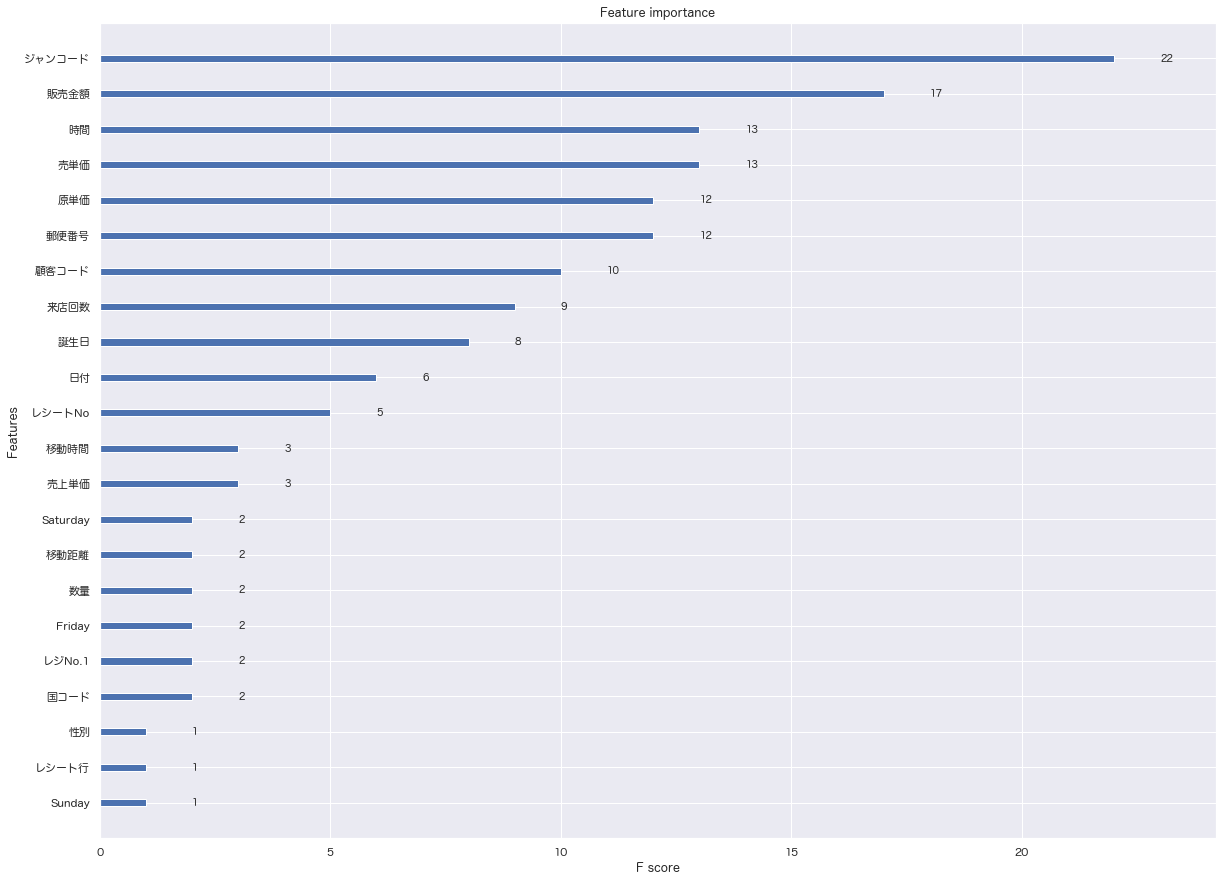

In [46]:
print("各変数の重要度をプロット")
plt.rcParams["figure.figsize"] = [20,15]
plt.rcParams["font.size"] = 10
xgb.plot_importance(xgb_model);

## 学習曲線

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve
print("学習曲線のライブラリ")

学習曲線のライブラリ


In [48]:
print("決定木学習用の関数")
def dt_training():
    dt_model = DecisionTreeRegressor(max_depth=5, max_features=5, max_leaf_nodes =10, random_state=42).fit(X_train, y_train)
    dt_predict = dt_model.predict(X_test)
    
    dt_pred = np.where(dt_predict > 0.5, 1, 0)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, dt_pred)
    auc = metrics.auc(fpr, tpr)

    return dt_model, dt_pred, auc

決定木学習用の関数


In [49]:
print("学習曲線描画用の関数")
def plot_learning_curve(model, X_data, y_data):
    # データ準備
    train_sizes, train_scores, val_scores = learning_curve(model, X=X_data, y=y_data, train_sizes = np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)
    
    # プロット準備
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Traing score と Val score をプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation score")

    # 標準偏差の範囲を色付け
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.2)
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color="g", alpha=0.2)

    # Y軸の範囲
    plt.ylim(0.0, 1.0)

    # 凡例の表示位置
    plt.grid()
    plt.legend(loc="best")
    plt.show();

学習曲線描画用の関数


### 決定木（比較用）

In [50]:
print("決定木の学習を実施")
dt_model, dt_pred, auc = dt_training();

決定木の学習を実施


学習曲線の描画


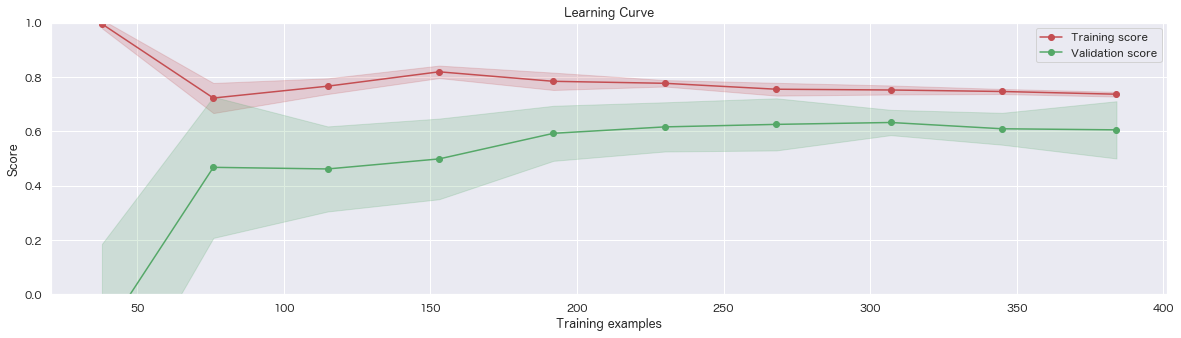

In [51]:
plt.rcParams["figure.figsize"] = [20,5]
plt.rcParams["font.size"] = 10

print("学習曲線の描画")
plot_learning_curve(dt_model, X_train, y_train);

### サポートベクトルマシン（比較用）

学習曲線の描画


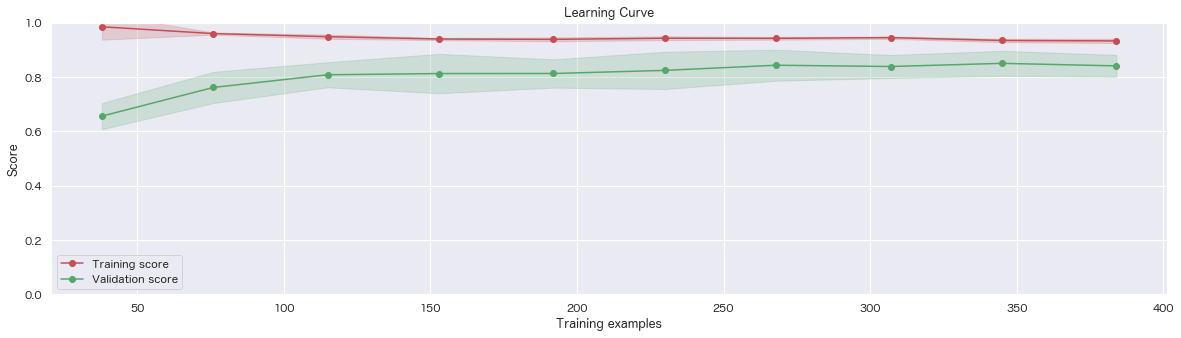

In [52]:
print("学習曲線の描画")
plot_learning_curve(svm_model, X_train, y_train);

### K近傍法

学習曲線の描画


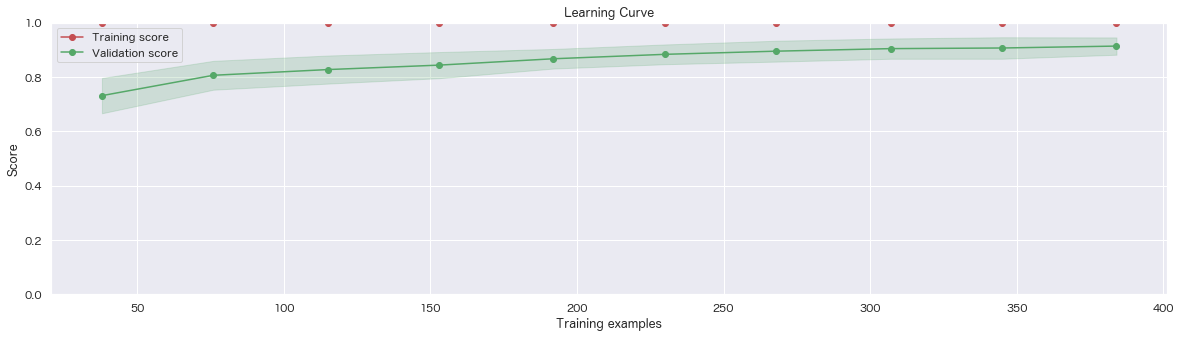

In [53]:
print("学習曲線の描画")
plt.rcParams["figure.figsize"] = [20,5]
plot_learning_curve(kn_model_skf, X_train, y_train);

#### 考察

- 決定木  
訓練、検証データともに、近しい評価結果が出ており、過学習はしていなそう。  
ただスコアが80%を下回っており、全体的に学習が足りていない可能性がある。  
  
  
- サポートベクトルマシン  
訓練、検証データともにスコアが高く、よく学習できていると思われる。(ちょっと高すぎる？)  
  
  
- K近傍法  
訓練データに過剰適合していそう。  
検証データに対してのスコアが低い。汎化性能は低い。。  
訓練データにノイズが多いのではないか。  

## AUC

### 各変数単体のAUC

In [54]:
print("各変数単体のAUC算出用の関数")
def get_auc_list():
    print('初期化')
    column_list = []
    auc_list = []
    cols = df_sample.columns[1:]
    
    print('学習')
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    for col in cols:
        for train_index_dt, val_index_dt in kf.split(df_sample.index):
            X_train_dt = df_sample[[col]].iloc[train_index_dt]
            y_train_dt = df_sample['購入フラグ'].iloc[train_index_dt]
            X_test_dt = df_sample[[col]].iloc[val_index_dt]
            y_test_dt = df_sample['購入フラグ'].iloc[val_index_dt]

            dt_model = DecisionTreeRegressor(
                max_depth=5, 
                max_leaf_nodes =10, random_state=42)
            dt_model.fit(X_train_dt, y_train_dt)

        dt_predict = dt_model.predict(X_test_dt)

        fpr, tpr, thresholds = metrics.roc_curve(y_test_dt, dt_predict)
        auc = metrics.auc(fpr, tpr)
        auc_list.append(auc.round(decimals=3))
        column_list.append(col)

    tree_auc = pd.DataFrame()
    tree_auc['カラム名'] = column_list
    tree_auc['AUC'] = auc_list
    tree_auc
    
    return tree_auc

各変数単体のAUC算出用の関数


In [55]:
print("各変数単体のAUC")
list = get_auc_list()
auc_list = list.sort_values(by='AUC', ascending=False).astype(str)
auc_list['順位'] = list.index+1
auc_list

各変数単体のAUC
初期化
学習


,カラム名,AUC,順位
12,ジャンコード,0.978,1
21,原単価,0.956,2
18,売単価,0.941,3
20,販売金額,0.937,4
23,売上単価,0.912,5
13,国コード,0.7,6
17,数量,0.63,7
1,性別,0.606,8
0,顧客コード,0.605,9
9,移動距離,0.57,10


## 特徴量の再精査

## 考察

<p>ジャンコードは、国コード、商品コード、アイテムコードに分解してみる</p>
<p>曜日は、金、土、日曜日のみに絞ってみる</p>
<p>レジは、レジNo.5に絞ってみる</p>
<p>日付時間のみ残し、日付、時間項目は除外してみる</p>
<p>移動距離は残し、移動時間が除外してみる</p>
<p>市区町村は残し、都道府県は除外してみる</p>
<p>都道府県フラグも不要とする</p>
<p>顧客コードは、共通番号部分は削除し、固有番号のみを残してみる</p>
<p>買物可能フラグは不要とする</p>
<p>レシート行分類は不要とする</p>

# パラメータ・チューニング

## パラメータ・サーチ（パラメータ単体）

n_neighborsサーチ


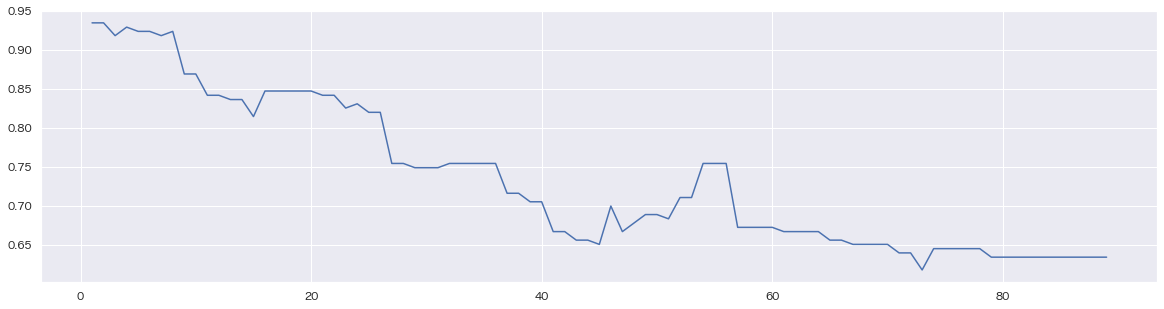

In [56]:
print("n_neighborsサーチ")
accuracy = []
k_range = range(1, 90)
for k in range(1, 90):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_kn = knn.predict(X_test)
    accuracy.append(metrics.accuracy_score(y_test, y_pred_kn))

plt.grid()
plt.plot(k_range, accuracy);

pサーチ


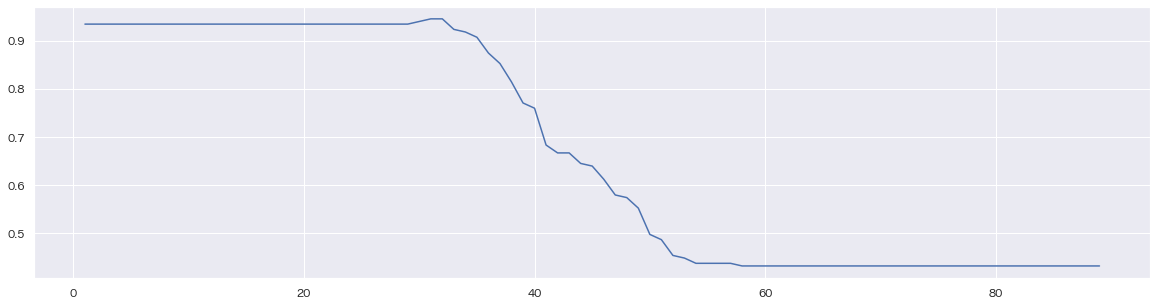

In [57]:
print("pサーチ")
accuracy = []
k_range = range(1, 90)
for k in range(1, 90):
    knn = KNeighborsClassifier(n_neighbors=1, p=k)
    knn.fit(X_train, y_train)
    y_pred_kn = knn.predict(X_test)
    accuracy.append(metrics.accuracy_score(y_test, y_pred_kn))

plt.grid()
plt.plot(k_range, accuracy);

## ランダムサーチ、グリッドサーチ

In [58]:
# あたりをつける
print("ランダムサーチでパラメーターサーチ(広範囲用)")
def random_search(model_param_set_random):
    max_score = 0
    best_model = None
    best_param = None
        
    for model, param in tqdm(model_param_set_random.items()):
        clf = RandomizedSearchCV(model, param)
        clf.fit(train_X, train_y)
        pred_y = clf.predict(test_X)
        score = f1_score(test_y, pred_y, average="micro")

        if max_score < score:
            max_score = score
            best_model = model.__class__.__name__
            best_param = clf.best_estimator_ # best_params_

    print("学習モデル:{},\nパラメーター:{}".format(best_model, best_param))
    print("ベストスコア:", max_score)

ランダムサーチでパラメーターサーチ(広範囲用)


In [59]:
print("グリッドサーチでパラメーターサーチ（狭範囲用）")
def grid_search(model_param_set_grid):
    max_score = 0
    best_model = None
    best_param = None

    for model, param in tqdm(model_param_set_grid.items()):
        clf = GridSearchCV(model, param)
        clf.fit(train_X, train_y)
        pred_y = clf.predict(test_X)
        score = f1_score(test_y, pred_y, average="micro")

        if max_score < score:
            max_score = score
            best_model = model.__class__.__name__
            best_param = clf.best_params_

    print("学習モデル:{},\nパラメーター:{}".format(best_model, best_param))
    print("ベストスコア:",max_score)

グリッドサーチでパラメーターサーチ（狭範囲用）


In [60]:
print("ランダムサーチ")
model_param_set_random = { # パラメーターをセット
    KNeighborsClassifier(): {
        "n_neighbors": [i for i in range(1, 100)], # 近傍オブジェクト数
        "p": [i for i in range(1, 100)], # 
        "leaf_size":  [i for i in range(1, 100)], # リーフサイズ
        "n_jobs": [i for i in range(0, 10)] # 近傍検索ジョブ数
    }
}
random_search(model_param_set_random)

  0%|          | 0/1 [00:00<?, ?it/s]

ランダムサーチ


/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/Ta

学習モデル:KNeighborsClassifier,
パラメーター:KNeighborsClassifier(leaf_size=43, n_jobs=9, n_neighbors=37, p=13)
ベストスコア: 0.7158469945355191


In [61]:
print("グリッドサーチ")
model_param_set_grid = {
    KNeighborsClassifier(): {
        "n_neighbors": [i for i in range(1, 10)],
        "p": [i for i in range(20, 40)]
    }
}
grid_search(model_param_set_grid)

  0%|          | 0/1 [00:00<?, ?it/s]

グリッドサーチ


100%|██████████| 1/1 [00:29<00:00, 29.14s/it]

学習モデル:KNeighborsClassifier,
パラメーター:{'n_neighbors': 1, 'p': 20}
ベストスコア: 0.9344262295081968


#### 考察

グリッドサーチのサーチ結果と異なる。pパラメータは、20~40の範囲で探索する。  

# 再学習

下記、２パターン（①②）のデータでの学習を実施する。  
①アンダーサンプリングしたデータの特徴量の内、上位10件のデータ    
②主成分分析により抽出した第２０成分までのデータ    

## 重要度（上位10件）

### XGBoost

In [62]:
top_importances = ['購入フラグ', 'ジャンコード', '原単価', '売単価', '販売金額', '売上単価', '国コード', '数量', '性別', '顧客コード', '移動距離']
top_imp = df_sample[top_importances].copy()

In [63]:
print("StratifiedKHold用のXGBoost用のデータ")
top_imp_skf = top_imp.astype(float).copy()
target = '購入フラグ'
Xtrain = top_imp_skf.drop(columns=target)
ytrain = top_imp_skf[target]

print("パラメータ")
xgb_params_skf = {
    'boosting_type': 'gbdt',
    'objective': 'binary:logistic', 
    'metric': {'binary_error'},
    'num_leaves': 100,
    'num_iterations':100,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'max_depth':10,
    'colsample_bytree':1,
    'n_estimators':500,
    'vervose': 0,
    'num_boost_round': 100,
    'early_stopping_rounds': 100,
    'verbose_eval': 50,
}

print("学習")
auc_scores_skf = []
xgb_predict_skf_list = []
y_val_skf_list = []
cv = StratifiedKFold(n_splits=7, random_state=0, shuffle=True)
for trn_index, val_index in tqdm(cv.split(Xtrain, ytrain)):
    X_trn, X_val = Xtrain.loc[trn_index], Xtrain.loc[val_index]
    y_trn, y_val = ytrain[trn_index], ytrain[val_index]
    y_val_skf_list.append(y_val)

    xgb_train_skf = xgb.DMatrix(X_trn, label=y_trn)
    xgb_test_skf = xgb.DMatrix(X_val, label=y_val)

    evals_skf = [(xgb_train_skf, 'train'), (xgb_test_skf, 'eval')]
    evals_result_skf = {}

    xgb_model_skf = xgb.train(
                xgb_params_skf,
                xgb_train_skf,
                evals=evals_skf,
                evals_result=evals_result_skf,
                )
    xgb_predict_skf = xgb_model_skf.predict(xgb_test_skf)
    xgb_predict_skf_list.append(xgb_predict_skf)

    fpr, tpr, thresholds = metrics.roc_curve(y_val, xgb_predict_skf)
    auc_skf = metrics.auc(fpr, tpr)
    auc_scores_skf.append(auc_skf)

0it [00:00, ?it/s]

StratifiedKHold用のXGBoost用のデータ
パラメータ
学習
[21:15:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, early_stopping_rounds, feature_fraction, metric, n_estimators, num_boost_round, num_iterations, num_leaves, verbose_eval, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:15:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behav

2it [00:00, 14.23it/s]

[21:15:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, early_stopping_rounds, feature_fraction, metric, n_estimators, num_boost_round, num_iterations, num_leaves, verbose_eval, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:15:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68491	eval-log

4it [00:00, 14.63it/s]

[21:15:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, early_stopping_rounds, feature_fraction, metric, n_estimators, num_boost_round, num_iterations, num_leaves, verbose_eval, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:15:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68510	eval-log

6it [00:00, 14.54it/s]

[21:15:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, early_stopping_rounds, feature_fraction, metric, n_estimators, num_boost_round, num_iterations, num_leaves, verbose_eval, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:15:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68525	eval-log

limit_output extension: Maximum message size of 10000 exceeded with 10038 characters

In [64]:
np.mean(auc_scores_skf).round(decimals=3)

0.961

StratifiedKHoldでのXGBoostの評価（全量)  
Accuracy：0.934  

In [65]:
print("StratifiedKHoldでのXGBoostの評価（重要度上位１０件）")
acc_list = []
prec_list = []
recl_list = []
f1_list = []
i = 0
for predict in tqdm(xgb_predict_skf_list):
    pred_skf = np.where(predict > 0.5, 1, 0)
    accuracy = accuracy_score(y_val_skf_list[i], pred_skf).round(decimals=3)
    precision = precision_score(y_val_skf_list[i], pred_skf).round(decimals=3)
    recall = recall_score(y_val_skf_list[i], pred_skf).round(decimals=3)
    f1 = f1_score(y_val_skf_list[i], pred_skf).round(decimals=3)
    
    acc_list.append(accuracy)
    prec_list.append(precision)    
    recl_list.append(recall)
    f1_list.append(f1)
    i=i+1

acc = np.mean(acc_list).mean().round(decimals=3)
prec = np.mean(prec_list).mean().round(decimals=3)
recl = np.mean(recl_list).mean().round(decimals=3)
f = np.mean(f1_list).mean().round(decimals=3)
print(f'正解率: {acc}')
print(f'適合率: {prec}')
print(f'再現率: {recl}')
print(f'F値: {f}')

  0%|          | 0/7 [00:00<?, ?it/s]

StratifiedKHoldでのXGBoostの評価（重要度上位１０件）


100%|██████████| 7/7 [00:00<00:00, 140.27it/s]

正解率: 0.928
適合率: 0.912
再現率: 0.947
F値: 0.929


StratifiedKHoldでのXGBoostの評価（全量）  
正解率: 0.893  
適合率: 0.898  
再現率: 0.888  
F値: 0.893  

「全量」→「重要度上位１０件」、評価の向上が見られる。  

### K近傍法（分類）

In [66]:
print("StratifiedKFold")
i = 1
knc_models_skf = []
knc_predicts_skf = []
acc_results_skf = []
y_vals_skf = []

target = '購入フラグ'
Xtrain_skf = top_imp.drop(columns=target)
ytrain_skf = top_imp[target]
cv = StratifiedKFold(n_splits=7, random_state=0, shuffle=True)
knc_model_skf = KNeighborsClassifier(n_neighbors=1, p=34)

for trn_index, val_index in tqdm(cv.split(Xtrain_skf, ytrain_skf)):
    X_trn, X_val = Xtrain_skf.loc[trn_index], Xtrain_skf.loc[val_index]
    y_trn, y_val = ytrain_skf[trn_index], ytrain_skf[val_index]
    y_vals_skf.append(y_val)

    knc_model_skf.fit(X_trn, y_trn) # 学習
    knc_models_skf.append(knc_model_skf) # モデル格納
    knc_predict_skf = knc_model_skf.predict_proba(X_val)[:, 1] # 予測
    knc_predicts_skf.append(knc_predict_skf)

    acc = knc_model_skf.score(X_val, y_val) # 評価
    acc_results_skf.append(acc)

accuracy_mean = np.mean(acc_results_skf).round(decimals=3)
print(f'平均正解率 {accuracy_mean}')

StratifiedKFold


0it [00:00, ?it/s]

KNeighborsClassifier(n_neighbors=1, p=34)

KNeighborsClassifier(n_neighbors=1, p=34)

KNeighborsClassifier(n_neighbors=1, p=34)

KNeighborsClassifier(n_neighbors=1, p=34)

4it [00:00, 37.79it/s]

KNeighborsClassifier(n_neighbors=1, p=34)

KNeighborsClassifier(n_neighbors=1, p=34)

KNeighborsClassifier(n_neighbors=1, p=34)

7it [00:00, 39.89it/s]

平均正解率 0.966


In [67]:
accuracy_mean = np.mean(acc_results_skf).round(decimals=3)
print(f'平均正解率 {accuracy_mean}')

平均正解率 0.966


In [68]:
print("StratifiedKHoldでのK近傍法の評価（重要度上位１０件）")
acc_list = []
prec_list = []
recl_list = []
f1_list = []
i = 0
for predict in tqdm(kn_predicts_skf):
    pred_skf = np.where(predict > 0.5, 1, 0)
    accuracy = accuracy_score(y_vals_skf[i], pred_skf).round(decimals=3)
    precision = precision_score(y_vals_skf[i], pred_skf).round(decimals=3)
    recall = recall_score(y_vals_skf[i], pred_skf).round(decimals=3)
    f1 = f1_score(y_vals_skf[i], pred_skf).round(decimals=3)
    
    acc_list.append(accuracy)
    prec_list.append(precision)
    recl_list.append(recall)
    f1_list.append(f1)
    i=i+1

acc = np.mean(acc_list).mean().round(decimals=3)
prec = np.mean(prec_list).mean().round(decimals=3)
recl = np.mean(recl_list).mean().round(decimals=3)
f = np.mean(f1_list).mean().round(decimals=3)
print(f'正解率: {acc}')
print(f'適合率: {prec}')
print(f'再現率: {recl}')
print(f'F値: {f}')

100%|██████████| 7/7 [00:00<00:00, 230.49it/s]

StratifiedKHoldでのK近傍法の評価（重要度上位１０件）
正解率: 0.958
適合率: 0.977
再現率: 0.938
F値: 0.956


StratifiedKHoldでのK近傍法の評価（全量）  
正解率: 0.958  
適合率: 0.977  
再現率: 0.938  
F値: 0.956  

K近傍法：平均正解率 0.966  
XGBoost：平均正解率0.961  

## 主成分（上位20成分）

In [69]:
principal = pd.read_csv("./principal.csv")
principal_= pd.DataFrame()
principal_ = principal.drop(columns='Unnamed: 0', axis=0).astype(float).round(decimals=3).astype(str)
principal_.head(2)

,購入フラグ,第1主成分,第2主成分,第3主成分,第4主成分,第5主成分,第6主成分,第7主成分,第8主成分,第9主成分,...,第11主成分,第12主成分,第13主成分,第14主成分,第15主成分,第16主成分,第17主成分,第18主成分,第19主成分,第20主成分
0,0.0,-0.253,-0.27,0.815,-0.756,-2.182,1.125,0.866,-0.342,-0.308,...,1.316,-1.609,-1.152,-0.198,1.567,0.347,0.606,0.395,-0.544,0.423
1,0.0,-0.331,-0.68,3.739,-0.156,-0.166,1.223,0.814,-0.461,-0.552,...,1.395,-1.697,-1.103,-0.218,1.325,0.721,0.093,-1.111,-0.04,0.46


In [87]:
principal_skf = principal_.astype(float).copy()
target = '購入フラグ'
Xtrain = principal_skf.drop(columns=target)
ytrain = principal_skf[target]

print("パラメータ")
xgb_params_skf = {
    'boosting_type': 'gbdt',
    'objective': 'binary:logistic', 
    'metric': {'binary_error'},
    'num_leaves': 100,
    'num_iterations':100,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'max_depth':10,
    'colsample_bytree':1,
    'n_estimators':500,
    'vervose': 0,
    'num_boost_round': 100,
    'early_stopping_rounds': 100,
    'verbose_eval': 50,
}

print("学習")
auc_scores_skf = []
xgb_predict_skf_list = []
y_val_skf_list = []
cv = StratifiedKFold(n_splits=7, random_state=0, shuffle=True)
for trn_index, val_index in tqdm(cv.split(Xtrain, ytrain)):
    X_trn, X_val = Xtrain.loc[trn_index], Xtrain.loc[val_index]
    y_trn, y_val = ytrain[trn_index], ytrain[val_index]
    y_val_skf_list.append(y_val)

    xgb_train_skf = xgb.DMatrix(X_trn, label=y_trn)
    xgb_test_skf = xgb.DMatrix(X_val, label=y_val)

    evals_skf = [(xgb_train_skf, 'train'), (xgb_test_skf, 'eval')]
    evals_result_skf = {}

    xgb_model_skf = xgb.train(
                xgb_params_skf,
                xgb_train_skf,
                evals=evals_skf,
                evals_result=evals_result_skf,
                )
    xgb_predict_skf = xgb_model_skf.predict(xgb_test_skf)
    xgb_predict_skf_list.append(xgb_predict_skf)

    fpr, tpr, thresholds = metrics.roc_curve(y_val, xgb_predict_skf)
    auc_skf = metrics.auc(fpr, tpr)
    auc_scores_skf.append(auc_skf)

0it [00:00, ?it/s]

パラメータ
学習
[16:01:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, early_stopping_rounds, feature_fraction, metric, n_estimators, num_boost_round, num_iterations, num_leaves, verbose_eval, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:01:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68348

1it [00:02,  2.84s/it]

[16:01:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, early_stopping_rounds, feature_fraction, metric, n_estimators, num_boost_round, num_iterations, num_leaves, verbose_eval, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:01:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68348	eval-log

2it [00:05,  2.69s/it]

[16:01:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, early_stopping_rounds, feature_fraction, metric, n_estimators, num_boost_round, num_iterations, num_leaves, verbose_eval, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:01:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68348	eval-log

3it [00:07,  2.58s/it]

[16:01:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, early_stopping_rounds, feature_fraction, metric, n_estimators, num_boost_round, num_iterations, num_leaves, verbose_eval, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:01:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68348	eval-log

4it [00:09,  2.52s/it]

[16:01:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, early_stopping_rounds, feature_fraction, metric, n_estimators, num_boost_round, num_iterations, num_leaves, verbose_eval, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:01:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68348	eval-log

5it [00:12,  2.46s/it]

[16:01:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, early_stopping_rounds, feature_fraction, metric, n_estimators, num_boost_round, num_iterations, num_leaves, verbose_eval, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:01:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68348	eval-log

6it [00:14,  2.46s/it]

[16:01:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, early_stopping_rounds, feature_fraction, metric, n_estimators, num_boost_round, num_iterations, num_leaves, verbose_eval, vervose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:01:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68348	eval-log

limit_output extension: Maximum message size of 10000 exceeded with 10030 characters

In [91]:
accuracy_mean = np.mean(auc_scores_skf).round(decimals=3)
print(f'平均正解率 {accuracy_mean}')

平均正解率 0.741


# 再パラメータ・チューニング

## XGBoost

In [73]:
target = '購入フラグ'
X_pc = top_imp.drop(columns=target)
y_pc = top_imp[target]
train_X_pc, test_X_pc, train_y_pc, test_y_pc = train_test_split(X_pc, y_pc, test_size=0.3, random_state=42);

In [74]:
print("あたりをつける")
def random_search2(model_param_set_random_pc):
    max_score_pc = 0
    best_model_pc = None
    best_param_pc = None
        
    for model, param in tqdm(model_param_set_random_pc.items()):
        clf_pc = RandomizedSearchCV(model, param)
        clf_pc.fit(train_X_pc, train_y_pc)
        pred_y_pc = clf_pc.predict(test_X_pc)
        score_pc = f1_score(test_y_pc, pred_y_pc, average="micro")

        if max_score_pc < score_pc:
            max_score_pc = score_pc
            best_model_pc = model.__class__.__name__
            best_param_pc = clf_pc.best_estimator_
    
    return best_model_pc, best_param_pc, max_score_pc

あたりをつける


In [75]:
print("パラメーターをセット")
model_param_set_random = {
    xgb.XGBClassifier(): {
        "num_leaves": [i for i in range(30, 200)],
        "num_iterations": [i for i in range(50, 200)],
        "learning_rate": [i for i in (format(i*0.01, '.2f') for i in range(1,10))],
        "feature_fraction": [i for i in (format(i*0.1, '.1f') for i in range(5,10))],
        "bagging_fraction": [i for i in (format(i*0.01, '.2f') for i in range(5,10))],
        "bagging_freq": [i for i in range(1, 20)],
        "max_depth": [i for i in range(1, 20)],
        "colsample_bytree": [i for i in range(1, 10)],
        "n_estimators": [i for i in range(50, 200)],
        "vervose": [i for i in range(1, 10)]
    }
}
print("ランダムサーチ")
best_model_pc, best_param_pc, max_score_pc = random_search2(model_param_set_random)

  0%|          | 0/1 [00:00<?, ?it/s]

パラメーターをセット
ランダムサーチ


/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site

limit_output extension: Maximum message size of 10000 exceeded with 19137 characters

In [76]:
print("学習モデル:{},\nパラメーター:{}".format(best_model_pc, best_param_pc))
print("ベストスコア:", max_score_pc)

学習モデル:XGBClassifier,
パラメーター:XGBClassifier(bagging_fraction='0.05', bagging_freq=8, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, feature_fraction='0.9', gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate='0.07', max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=193, n_jobs=8, num_iterations=175, num_leaves=144,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, ...)
ベストスコア: 0.9398907103825137


In [77]:
def run_xgb(target_param, k_range):
    import xgboost as xgb
    top_importances = ['購入フラグ', 'ジャンコード', '原単価', '売単価', '販売金額', '売上単価', '国コード', '数量', '性別', '顧客コード', '移動距離']
    top_imp = df_sample[top_importances].copy()

    target = '購入フラグ'
    X = top_imp.drop(columns=target)
    y = top_imp[target]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42);

    xgb_train = xgb.DMatrix(train_X, label=train_y)
    xgb_test = xgb.DMatrix(test_X, label=test_y)

    accuracy_list = []
    k_list = []
    params_list=[]
    for k in k_range:
        k_list.append(k)
        params = {
            'boosting_type': 'gbdt',
            'objective': 'binary:logistic', 
            'metric': {'binary_error'},
            'num_leaves': 110,
            'num_iterations':120,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 3,
            'max_depth':7,
            'colsample_bytree':0.3
        }
        params.update({target_param: k})

        model_chun = xgb.train(
                    params,
                    xgb_train
                    )
        predict_chun = model_chun.predict(xgb_test)
        pred_chun =  np.where(predict_chun > 0.5, 1, 0)
        accuracy = metrics.accuracy_score(test_y, pred_chun)
        accuracy_list.append(accuracy)
        
    return accuracy_list

In [78]:
print("XGBoostサーチ")
target_param = 'colsample_bytree'
# k_range = range(100, 1000)
k_range = [format(i*0.1, '.1f') for i in range(1,10)]
# k_range = [format(i*0.01, '.2f') for i in range(1,10)]
accuracy_list = run_xgb(target_param, k_range)

XGBoostサーチ
[21:15:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, feature_fraction, metric, num_iterations, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:15:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:15:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/x

0.907


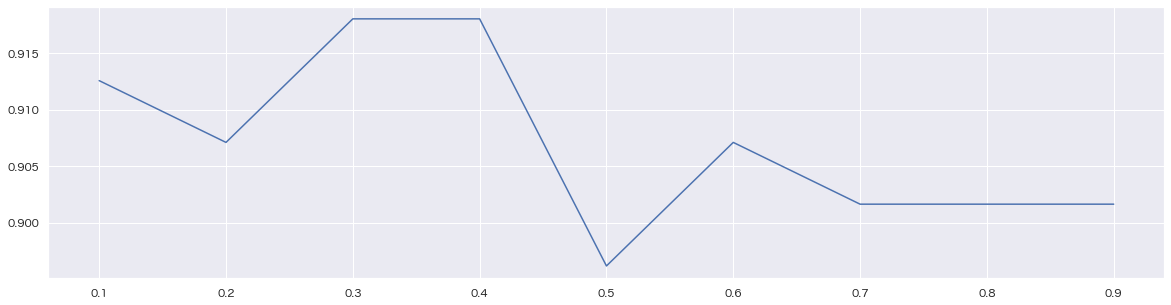

In [79]:
print(np.mean(accuracy_list).round(decimals=3))
plt.grid()
plt.plot(k_range, accuracy_list);

最終値  
boosting_type: gbdt,    
objective: binary:logistic,     
metric: {binary_error},    
num_leaves: 110,    
num_iterations:120,    
learning_rate: 0.04,    
feature_fraction: 0.9,    
bagging_fraction: 0.8,    
bagging_freq: 3,    
max_depth:7,    
colsample_bytree:0.3

## K近傍法（分類）

In [80]:
print("ランダムサーチ")
model_param_set_random = {
    KNeighborsClassifier(): {
        "n_neighbors": [i for i in range(1, 100)],
        "p": [i for i in range(1, 100)],
        "leaf_size":  [i for i in range(1, 100)],
        "n_jobs": [i for i in range(0, 10)]
    }
}
random_search2(model_param_set_random)

  0%|          | 0/1 [00:00<?, ?it/s]

ランダムサーチ


/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/Users/Ta

('KNeighborsClassifier',
 KNeighborsClassifier(leaf_size=14, n_jobs=9, n_neighbors=22, p=27),
 0.8469945355191257)

In [81]:
def run_kn(k_range):
    top_importances = ['購入フラグ', 'ジャンコード', '原単価', '売単価', '販売金額', '売上単価', '国コード', '数量', '性別', '顧客コード', '移動距離']
    top_imp = df_sample[top_importances].copy()

    target = '購入フラグ'
    Xtrain = top_imp.drop(columns=target)
    ytrain = top_imp[target]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

    accuracy_list = []
    for k in k_range:
        knc_model = KNeighborsClassifier(n_neighbors=4, p=k, leaf_size=7, n_jobs=5)
        knc_model.fit(train_X, train_y)

        knc_pred = knc_model.predict_proba(test_X)[:, 1]
        pred_chun =  np.where(knc_pred > 0.5, 1, 0)
        accuracy = metrics.accuracy_score(test_y, pred_chun)
        accuracy_list.append(accuracy)
        
    return accuracy_list

K近傍法サーチ
0.924


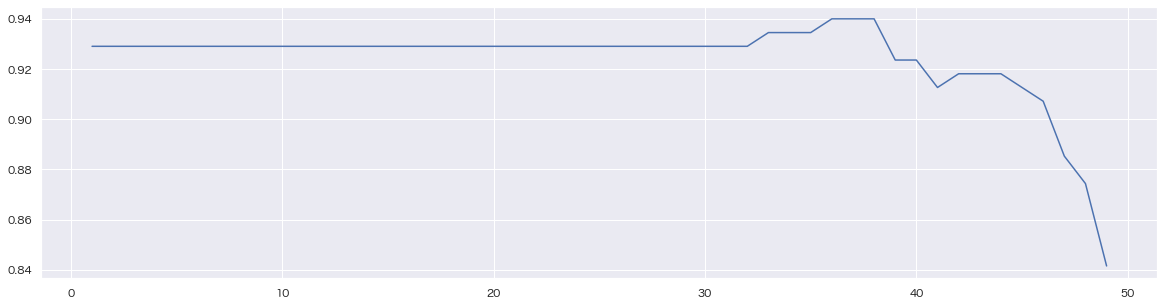

In [82]:
print("K近傍法サーチ")
from sklearn.neighbors import KNeighborsClassifier # K近傍法
k_range = range(1, 50)
accuracy_list = run_kn(k_range)
print(np.mean(accuracy_list).round(decimals=3))
plt.grid()
plt.plot(k_range, accuracy_list);

最終結果  
n_neighbors=4  
p=38  
leaf_size=7  
n_jobs=5  

# アンサンブル（スタッキング）

In [83]:
# データ準備
top_importances = ['購入フラグ', 'ジャンコード', '原単価', '売単価', '販売金額', '売上単価', '国コード', '数量', '性別', '顧客コード', '移動距離']
top_imp = df_sample[top_importances].astype(float).copy()

target = '購入フラグ'
Xtrain = top_imp.drop(columns=target)
ytrain = top_imp[target]
seed = 0

X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, random_state=seed)
StKFold = model_selection.StratifiedKFold(n_splits = 5, shuffle=True, random_state=seed) 
scores = {}

# XGBoost
xgb_params = {
            'boosting_type': 'gbdt',
            'objective': 'binary:logistic', 
            'metric': {'binary_error'},
            'num_leaves': 110,
            'num_iterations':120,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 3,
            'max_depth':7,
            'colsample_bytree':0.3
}
xgb_clf = XGBClassifier(**xgb_params)
xgb_clf.fit(X_train, y_train)

results = model_selection.cross_val_score(xgb_clf, Xtrain, ytrain, cv=StKFold)
scores[('1.XGBoost', 'train_score')] = results.mean().round(decimals=3).astype(str)
scores[('1.XGBoost', 'test_score')] = xgb_clf.score(X_test, y_test).round(decimals=3).astype(str)

# K近傍法（分類）
knc_clf = KNeighborsClassifier(n_neighbors=4, p=38, leaf_size=7, n_jobs=5)
knc_clf.fit(X_train, y_train)

results = model_selection.cross_val_score(knc_clf, X_test, y_test, cv = StKFold)
scores[('2.KNeighborsClassifier', 'train_score')] = results.mean().round(decimals=3).astype(str)
scores[('2.KNeighborsClassifier', 'test_score')] = knc_clf.score(X_test, y_test).round(decimals=3).astype(str)

# アンサンブル（スタッキング）
estimators=[('xgb', xgb_clf), ('knc', knc_clf)]
stk_clf=StackingClassifier(estimators=estimators, final_estimator=KNeighborsClassifier())
stk_clf.fit(X_train, y_train)
results = model_selection.cross_val_score(stk_clf, X_test, y_test, cv = StKFold) 
scores[('3.Stacking', 'train_score')] = results.mean().round(decimals=3).astype(str)
scores[('3.Stacking', 'test_score')] = stk_clf.score(X_test, y_test).round(decimals=3).astype(str)

/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:16:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, feature_fraction, metric, num_iterations, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:16:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(bagging_fraction=0.8, bagging_freq=3, base_score=0.5,
              booster='gbtree', boosting_type='gbdt', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, feature_fraction=0.9,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.04, max_delta_step=0,
              max_depth=7, metric={'binary_error'}, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=8, num_iterations=120, num_leaves=110, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, ...)

/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:16:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, feature_fraction, metric, num_iterations, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:16:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:16:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-spli

/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:16:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, feature_fraction, metric, num_iterations, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:16:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:16:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, feature_fraction, metric, num_iterations, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:16:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:16:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, feature_fraction, metric, num_iterations, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:16:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KNeighborsClassifier(leaf_size=7, n_jobs=5, n_neighbors=4, p=38)

/Users/Tatsuro-Tokume/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:16:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, boosting_type, feature_fraction, metric, num_iterations, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:16:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-

limit_output extension: Maximum message size of 10000 exceeded with 10297 characters

In [84]:
# モデル評価
pd.Series(scores).unstack()

,test_score,train_score
1.XGBoost,0.941,0.957
2.KNeighborsClassifier,0.778,0.688
3.Stacking,0.954,0.909
